In [101]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from scipy.special import gamma, jv

In [139]:
def generate_data(n=20):
    X = 10 * np.random.random(size=n).reshape(-1, 1)
#     y = np.sin(X).reshape(-1, 1) + 0.2 * np.random.randn()
#     y = 2 * X + 0.5 * np.random.randn(len(X), 1)
    y = 0.1 * X**2 + 0.2 * X + 1 + 3 * np.random.randn()
    
    return X, y

In [140]:
def squared_exponential_kernel(x1, x2, sigma_f, sigma_n, theta):
    t1 = sigma_f**2 * np.exp(-1/(2 * theta**2) * (x1 - x2)**2)
    t2 = sigma_n**2 * np.float(x1 == x2)
    return t1 + t2

def matern_kernel(x1, x2, p):
    k = 1 / (2**(p - 1) * gamma(p))
    x = 2 * np.sqrt(p) * np.linalg.norm(x1 - x2)
    f1 = x**p
    f2 = jv(p, x)
    return k * f1 * f2

def compute_K(X, kernel):
    K = np.zeros((X.shape[0], X.shape[0]))
    for i in range(X.shape[0]):
        for j in range(i, X.shape[0]):
            K[i, j] = kernel(X[i], X[j])
            K[j, i] = K[i, j]
    return K

def compute_k_new_observation(X, x_new, kernel):
    k = np.array([kernel(x_new, x) for x in X]).reshape(-1, 1)
    return k

def compute_mean(k, K_inv, f):
    return np.dot(k.T, np.dot(K_inv, f))

def compute_variance(x_new, k, K_inv, kernel):
    return kernel(x_new, x_new) - np.dot(k.T, np.dot(K_inv, k))

In [141]:
def compute_mean_var(X, y, x_new, kernel, K_inv):
    k = compute_k_new_observation(X, x_new, kernel=kernel)
    return compute_mean(k=k, K_inv=K_inv, f=y), compute_variance(x_new=x_new, k=k, K_inv=K_inv, kernel=kernel)

In [142]:
def plot_in_range(X, y, start, stop, kernel):
    X_new = np.arange(start, stop, 0.01)

    K = compute_K(X, kernel=kernel)
    K_inv = np.linalg.inv(K)
    
    means_sigmas = [compute_mean_var(X=X, y=y, x_new=x, kernel=kernel, K_inv=K_inv) for x in X_new]
    means = np.concatenate(list(zip(*means_sigmas))[0]).reshape(-1, 1)
    sigmas = np.concatenate(list(zip(*means_sigmas))[1]).reshape(-1, 1)
    
    plt.plot(X_new, means)
    plt.fill_between(
        X_new,
        (means - sigmas).reshape(-1),
        (means + sigmas).reshape(-1),
        alpha=0.1
    )
    plt.scatter(X, y)

### Find the optimal parameters for our covariance function by maximizing log(p(y|x, theta))

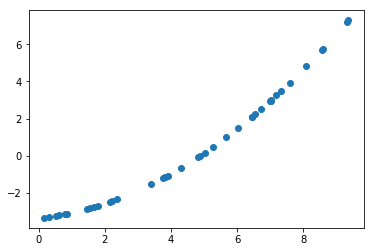

In [158]:
X, y = generate_data(n=40)
plt.scatter(X, y)

In [159]:
def log_p(params):
    params = params.flatten()
    theta, sigma_f, sigma_n = params[0], params[1], params[2]
    if theta == 0:
        return 0.
#     kernel = partial(matern_kernel, p=theta)
    kernel = partial(
        squared_exponential_kernel,
        theta=theta,
        sigma_f=sigma_f,
        sigma_n=sigma_n
    )
    K = compute_K(X, kernel=kernel)
    n = K.shape[0]
    K_inv = np.linalg.inv(K)

    t1 = -1/2 * np.dot(y.T, np.dot(K_inv, y))
    t2 = - 1/ 2 * np.log(np.linalg.det(K))
    t3 = - n / 2 * np.log(2 * np.pi)

    _log_p = t1 + t2 + t3
    
    return -_log_p

In [166]:
# x_nm = minimize_scalar(log_p, method='Bounded', bounds=[0.01, 2])
x_nm = minimize(log_p, x0=[0.1, 0.1, 0.1], method='Nelder-Mead', options={'xatol': 1e-5, 'maxiter':20})

SyntaxError: invalid syntax (<ipython-input-166-e7ec95e4cf0f>, line 2)

In [161]:
x_nm

 final_simplex: (array([[-9.99338949e-01,  2.73568733e+00, -2.38348270e-08],
       [-9.99338949e-01,  2.73568733e+00, -2.38348270e-08],
       [-9.99338949e-01,  2.73568733e+00, -2.38348270e-08],
       [-9.99338949e-01,  2.73568733e+00, -2.38348270e-08]]), array([-312.01130266, -250.48148138, -250.48148138, -241.23099451]))
           fun: -312.011302656498
       message: 'Maximum number of function evaluations has been exceeded.'
          nfev: 604
           nit: 231
        status: 1
       success: False
             x: array([-9.99338949e-01,  2.73568733e+00, -2.38348270e-08])

In [129]:
# xx = np.arange(0.001, x_nm.x + 0.05, 0.001)
# log_ps = np.array([log_p(x) for x in xx]).flatten()
# plt.plot(xx, log_ps)

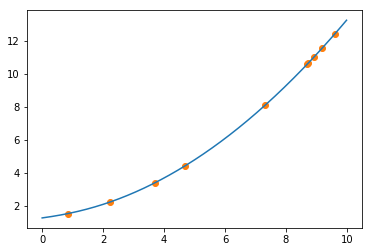

In [130]:
plot_in_range(
    start=0,
    stop=10,
    kernel=partial(
        squared_exponential_kernel,
        theta=x_nm.x[0],
        sigma_f=x_nm.x[1],
        sigma_n=x_nm.x[2]
    ),
    X=X,
    y=y
)